<a href="https://colab.research.google.com/github/adrianacupp/NLP_with_Transformers/blob/main/document_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import libraries and data

In [7]:
import re
# import umap
import nltk
import time
import os.path
from os import path
import pprint
import os.path
from os import path
import numpy as np
import pandas as pd
from string import *

In [8]:
import seaborn as sns
from spacy import displacy
import transformers as ppb

In [38]:
import torch
import torch.nn.functional as F

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

In [37]:
#pip install -U sentence-transformers

In [11]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score

In [127]:
from sklearn.decomposition import PCA

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#read the file
df = pd.read_excel('/content/input.xlsx')
print(df.head())
print(df.info())

                                              corpus
0  Gap-Based Education, Changing Competence, and ...
1    Science Education in the Preclinical Curriculum
2  SPECIAL TUBERCULOSIS EXAMINATIONS IN THE MILIT...
3  Adaptive tracking control design of constraine...
4  Archives of Internal Medicine Reader's Choice:...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   corpus  972 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB
None


## EDA

In [14]:
#how long are the titles?
df['length'] = df['corpus'].str.split().apply(len)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,972.0,10.195473,5.472792,2.0,7.0,9.0,13.0,47.0


<Axes: >

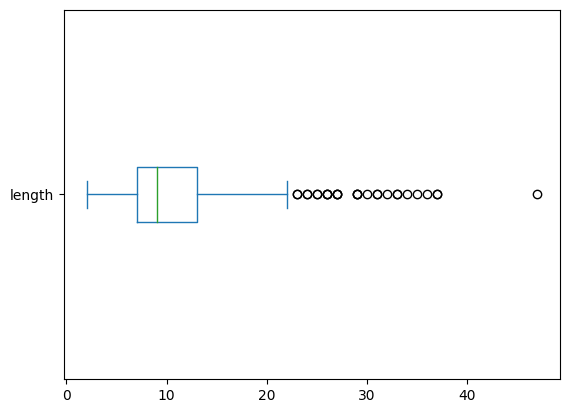

In [15]:
df['length'].plot(kind='box', vert=False)

<Axes: ylabel='Frequency'>

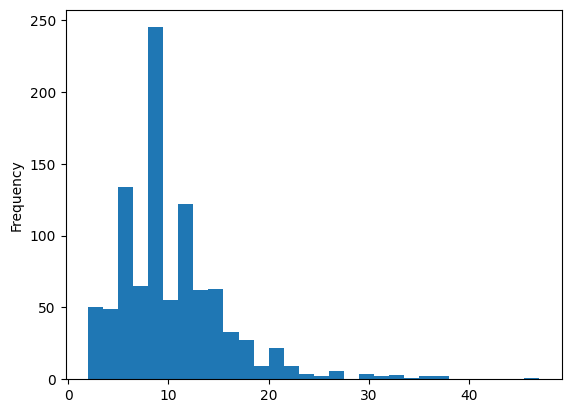

In [16]:
df['length'].plot(kind='hist', bins=30)

## BERT Base Implementation - Last Hidden State

> Aggiungi citazione



### Tokenizing

In [71]:
from transformers import AutoTokenizer

model_ckpt = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [73]:
#before tokenizing the data, I need to pass Pandas dataframe as a list of Series
texts = df['corpus'].tolist()
tokenized_texts = tokenizer(texts, padding=True, return_tensors='pt')

In [74]:
tokenized_texts['input_ids']

tensor([[  101,  6578,  1011,  ...,     0,     0,     0],
        [  101,  2671,  2495,  ...,     0,     0,     0],
        [  101,  2569, 15877,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2991,  ...,     0,     0,     0],
        [  101,  2474, 18143,  ...,     0,     0,     0],
        [  101,  4684,  8957,  ...,     0,     0,     0]])

In [75]:
tokenized_texts['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [76]:
print("Input IDs shape:", tokenized_texts['input_ids'].shape)
print("Attention mask shape:", tokenized_texts['attention_mask'].shape)

Input IDs shape: torch.Size([972, 108])
Attention mask shape: torch.Size([972, 108])


### Convert token encoding to embeddings

In [77]:
model_ckpt = "sentence-transformers/bert-base-nli-mean-tokens"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
inputs = {
    'input_ids': tokenized_texts['input_ids'],
    'attention_mask': tokenized_texts['attention_mask']
}

In [98]:
# Generate embeddings
with torch.no_grad():
    outputs = model(**inputs).last_hidden_state
    embeddings = outputs

In [99]:
embeddings.shape

torch.Size([972, 108, 768])

### Plot similarity matrix

In [104]:
# Calculate cosine similarity
embeddings_np = embeddings.numpy()
reshaped_embeddings = embeddings_np.reshape(embeddings_np.shape[0], -1)

similarity_matrix = cosine_similarity(reshaped_embeddings)

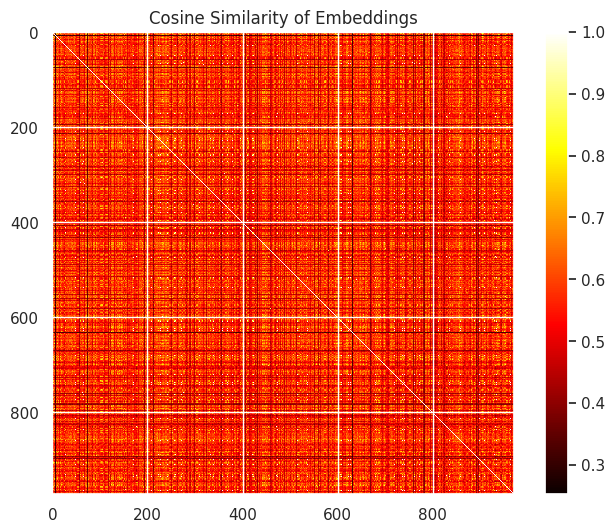

In [106]:
plt.figure(figsize=(8, 6))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.title('Cosine Similarity of Embeddings')
plt.colorbar()
plt.show()

## KMeans

Flatten embeddings

In [115]:
n_samples, sequence_length, embedding_dim = embeddings_np.shape
print( n_samples, sequence_length, embedding_dim)

972 108 768


In [118]:
embeddings_flat = embeddings_np.reshape(n_samples, sequence_length * embedding_dim)

Elbow Plot

In [120]:
def plot_elbow_method(embedding):

    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(embedding)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()


In [131]:
#plot_elbow_method(embeddings_flat)

In [135]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_np.reshape(n_samples, -1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Dimensionality Reduction

In [136]:
pca = PCA(n_components=2)
embeddings_reduced = pca.fit_transform(embeddings_np.reshape(n_samples, -1))

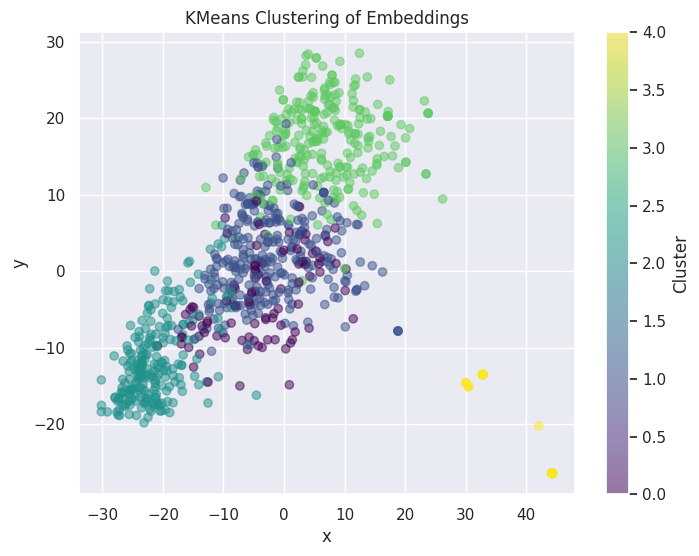

In [137]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering of Embeddings')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Cluster')
plt.show()